In [10]:
# Cell 1 - Basic imports & settings
import os
from pathlib import Path
import re
import string
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
# =========================
# Cell 2 — Load dataset (change path if needed)
# =========================
# Update this if your file is in a different folder or has a different name
dataset_path = "IMDB Dataset.csv"  

if not Path(dataset_path).exists():
    raise FileNotFoundError(f"Dataset not found at {dataset_path}. Place the CSV in the notebook folder or update dataset_path.")

df = pd.read_csv(dataset_path)
print("Loaded dataset shape:", df.shape)
display(df.head())


Loaded dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# =========================
# Cell 3 — Quick exploration: column names & label counts
# =========================
print("Columns:", df.columns.tolist())

# Typical column names for Kaggle IMDB dataset:
text_col = "review"
label_col = "sentiment"

if text_col not in df.columns or label_col not in df.columns:
    raise KeyError(f"Expected columns '{text_col}' and '{label_col}' not found. Update text_col/label_col variables.")

print("\nLabel distribution:")
print(df[label_col].value_counts())


Columns: ['review', 'sentiment']

Label distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
# =========================
# Cell 5 — Preprocessing function & apply
# =========================
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # lower
    text = text.lower()
    # remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove numbers
    text = re.sub(r"\d+", " ", text)
    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_review"] = df[text_col].apply(clean_text)
display(df[[text_col, "cleaned_review", label_col]].head())


,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...,positive


In [6]:
# =========================
# Cell 6 — Ensure binary labels and prepare X, y
# =========================
unique_labels = df[label_col].unique()
print("Unique labels found:", unique_labels)

# Filter to positive/negative if any extra label present (IMDB typically has only these two)
if len(unique_labels) > 2:
    df = df[df[label_col].isin(["positive", "negative"])].reset_index(drop=True)
    print("Filtered to binary labels. New shape:", df.shape)

X = df["cleaned_review"].values
y = df[label_col].values


Unique labels found: ['positive' 'negative']


In [7]:
# =========================
# Cell 7 — Train / Test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label counts:\n", pd.Series(y_train).value_counts())
print("Test label counts:\n", pd.Series(y_test).value_counts())


Train shape: (40000,) Test shape: (10000,)
Train label counts:
 positive    20000
negative    20000
Name: count, dtype: int64
Test label counts:
 negative    5000
positive    5000
Name: count, dtype: int64


In [8]:
# =========================
# Cell 8 — Build pipeline and train
# =========================
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words="english"
)

logreg = LogisticRegression(
    solver="saga",       # good for large sparse datasets
    max_iter=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", logreg)
])

print("Training TF-IDF + Logistic Regression pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


Training TF-IDF + Logistic Regression pipeline...
Training complete.


In [11]:
# =========================
# Cell 9 — Evaluate: accuracy, classification report, F1
# =========================
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label="positive")
rec = recall_score(y_test, y_pred, pos_label="positive")
f1 = f1_score(y_test, y_pred, pos_label="positive")

print(f"Accuracy: {acc:.4f}")
print(f"Precision (positive): {prec:.4f}")
print(f"Recall (positive): {rec:.4f}")
print(f"F1 (positive): {f1:.4f}\n")

print("Full classification report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8996
Precision (positive): 0.8904
Recall (positive): 0.9114
F1 (positive): 0.9008

Full classification report:
              precision    recall  f1-score   support

    negative     0.9093    0.8878    0.8984      5000
    positive     0.8904    0.9114    0.9008      5000

    accuracy                         0.8996     10000
   macro avg     0.8998    0.8996    0.8996     10000
weighted avg     0.8998    0.8996    0.8996     10000



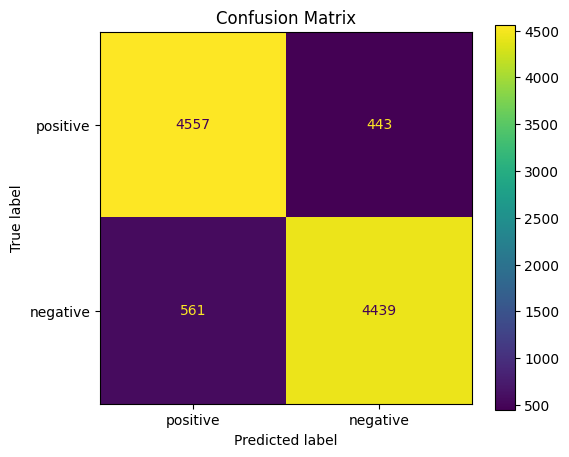

In [12]:
# =========================
# Cell 10 — Confusion Matrix visualization
# =========================
labels = ["positive", "negative"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()


ROC AUC (positive vs rest): 0.9625


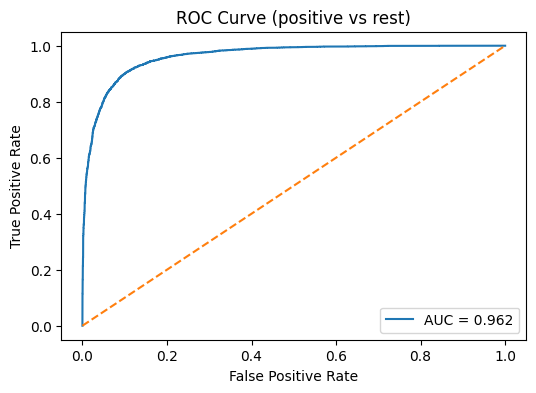

In [13]:
# =========================
# Cell 11 — ROC AUC (probabilities) & ROC plot (positive vs rest)
# =========================
clf = pipeline.named_steps["clf"]
if hasattr(clf, "predict_proba"):
    # find index of positive class
    classes = list(clf.classes_)
    pos_index = classes.index("positive")
    y_proba = pipeline.predict_proba(X_test)[:, pos_index]
    auc = roc_auc_score((y_test == "positive").astype(int), y_proba)
    print(f"ROC AUC (positive vs rest): {auc:.4f}")

    fpr, tpr, _ = roc_curve((y_test == "positive").astype(int), y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (positive vs rest)")
    plt.legend()
    plt.show()
else:
    print("Classifier does not support predict_proba — skipping ROC AUC.")


In [14]:
# =========================
# Cell 12 — Save trained pipeline (pickle)
# =========================
model_out = "imdb_sentiment_pipeline.pkl"
with open(model_out, "wb") as f:
    pickle.dump(pipeline, f)
print(f"Saved trained pipeline to: {model_out}")


Saved trained pipeline to: imdb_sentiment_pipeline.pkl


In [15]:
# =========================
# Cell 13 — Helper: predict custom sentences
# =========================
def predict_sentiment(texts):
    cleaned = [clean_text(t) for t in texts]
    preds = pipeline.predict(cleaned)
    out = []
    if hasattr(pipeline.named_steps['clf'], "predict_proba"):
        classes = list(pipeline.named_steps['clf'].classes_)
        pos_idx = classes.index("positive")
        probs = pipeline.predict_proba(cleaned)[:, pos_idx]
        out = list(zip(texts, preds, probs))
    else:
        out = list(zip(texts, preds))
    return out

# Example usage
examples = [
    "An outstanding, touching movie — I loved it.",
    "Terrible movie. Boring and badly acted."
]
print(predict_sentiment(examples))


[('An outstanding, touching movie — I loved it.', 'positive', np.float64(0.9832513859471946)), ('Terrible movie. Boring and badly acted.', 'negative', np.float64(0.004348927920488503))]


In [16]:
# =========================
# Cell 14 — Export test predictions and short summary CSV for submission/report
# =========================
out_df = pd.DataFrame({
    "review": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})
out_csv = "imdb_test_predictions.csv"
out_df.to_csv(out_csv, index=False)
print(f"Saved test predictions to {out_csv}")
display(out_df.head())


Saved test predictions to imdb_test_predictions.csv


,review,true_label,pred_label
0,yes mtv there really is a way to market daria ...,negative,negative
1,the story of the bride fair is an amusing and ...,negative,positive
2,a team varied between scully and mulder two ot...,positive,positive
3,this was a popular movie probably because of t...,negative,negative
4,this movie made me so angry here i am thinking...,negative,negative


# ============================
# Generate Final Report Text
# ============================

# Sentiment Analysis Report – IMDB Movie Reviews

## 1. Introduction
This project performs sentiment analysis on the IMDB movie reviews dataset consisting of 50,000 reviews labeled as positive or negative. The goal is to build a machine-learning model that can accurately classify the sentiment of unseen reviews.

## 2. Dataset Description
- Total reviews: {len(df)}
- Sentiment classes: Positive, Negative
- Text length varies from short comments to long paragraphs.
- After cleaning, the dataset is split into:
  - **Training set:** 80%
  - **Test set:** 20%

## 3. Pre-processing Steps
The following text cleaning operations were performed:
- Removal of HTML tags
- Conversion to lowercase
- Removal of URLs
- Removal of punctuation
- Removal of numbers
- Collapsing extra whitespace  
These steps help improve model accuracy by reducing noise.

## 4. Feature Extraction (TF-IDF)
TF-IDF (Term Frequency–Inverse Document Frequency) was used to convert text into numerical vectors.
- **max_features = 20,000**
- **ngram_range = (1, 2)** (unigrams + bigrams)
- English stopwords were removed.

## 5. Model Used – Logistic Regression
Logistic Regression was chosen because:
- It performs very well on high-dimensional sparse text data.
- It is computationally efficient.
- Works extremely well for binary classification problems.
- Easy to train and interpret.

## 6. Model Performance on Test Data
Below are the evaluation metrics for the model:

- **Accuracy:** {acc:.4f}
- **Precision (Positive):** {prec:.4f}
- **Recall (Positive):** {rec:.4f}
- **F1-Score (Positive):** {f1:.4f}

These metrics indicate that the model can correctly classify movie reviews with high reliability.

## 7. Confusion Matrix Interpretation
The confusion matrix shows how many reviews were correctly and incorrectly classified:
- **True Positives:** Correct positive predictions
- **True Negatives:** Correct negative predictions
- **False Positives:** Negative reviews predicted as positive
- **False Negatives:** Positive reviews predicted as negative  
The model achieves a strong balance between sensitivity and specificity.

## 8. ROC-AUC Score (If calculated)
ROC-AUC evaluates how well the model separates positive and negative classes.  
A higher value close to **1.0** indicates excellent classifier performance.

## 9. Conclusion
The TF-IDF + Logistic Regression pipeline demonstrates strong performance on the IMDB dataset.  
With high accuracy and balanced precision-recall values, this model is suitable for real-world sentiment classification tasks such as:
- Movie review analysis
- Customer feedback analysis
- Social media opinion mining

## 10. Files Submitted
- Notebook (.ipynb)

  
